<a href="https://colab.research.google.com/github/17092003vamsi/HUNTERs/blob/main/klu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Validation Accuracy: 89.31%
Test Accuracy: 92.86%

Classification Report (Test Set):
               precision    recall  f1-score   support

           0       1.00      0.98      0.99        46
           1       0.96      0.96      0.96        50
           2       0.87      0.96      0.91        50
           3       0.96      0.96      0.96        45
           4       0.92      0.82      0.87        40
           5       0.88      0.88      0.88        49

    accuracy                           0.93       280
   macro avg       0.93      0.93      0.93       280
weighted avg       0.93      0.93      0.93       280



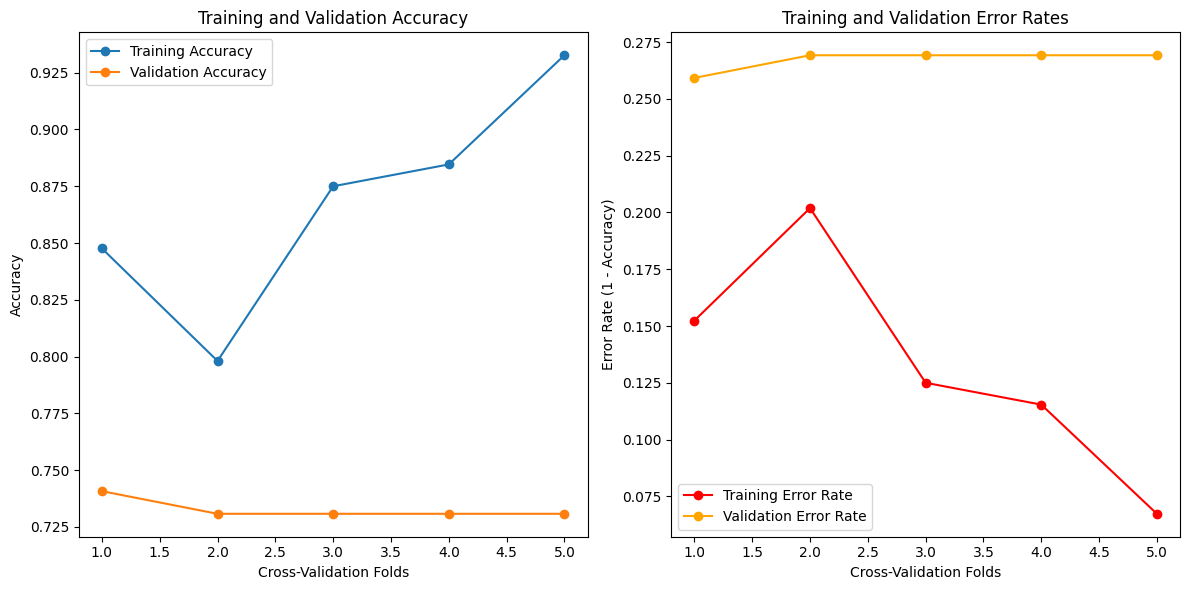

Class: A
  True Positives (TP): 45
  False Positives (FP): 0
  True Negatives (TN): 234
  False Negatives (FN): 1
------------------------------------------------
Class: A-S
  True Positives (TP): 48
  False Positives (FP): 2
  True Negatives (TN): 228
  False Negatives (FN): 2
------------------------------------------------
Class: G
  True Positives (TP): 48
  False Positives (FP): 7
  True Negatives (TN): 223
  False Negatives (FN): 2
------------------------------------------------
Class: G-S
  True Positives (TP): 43
  False Positives (FP): 2
  True Negatives (TN): 233
  False Negatives (FN): 2
------------------------------------------------
Class: HPM
  True Positives (TP): 33
  False Positives (FP): 3
  True Negatives (TN): 237
  False Negatives (FN): 7
------------------------------------------------
Class: HPM-S
  True Positives (TP): 43
  False Positives (FP): 6
  True Negatives (TN): 225
  False Negatives (FN): 6
------------------------------------------------


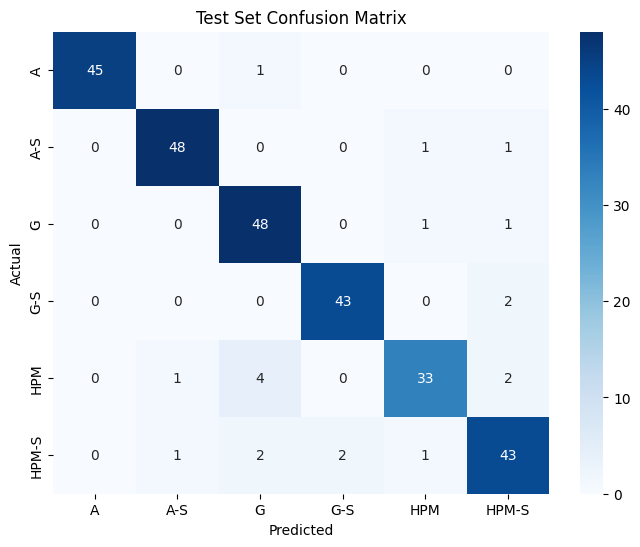

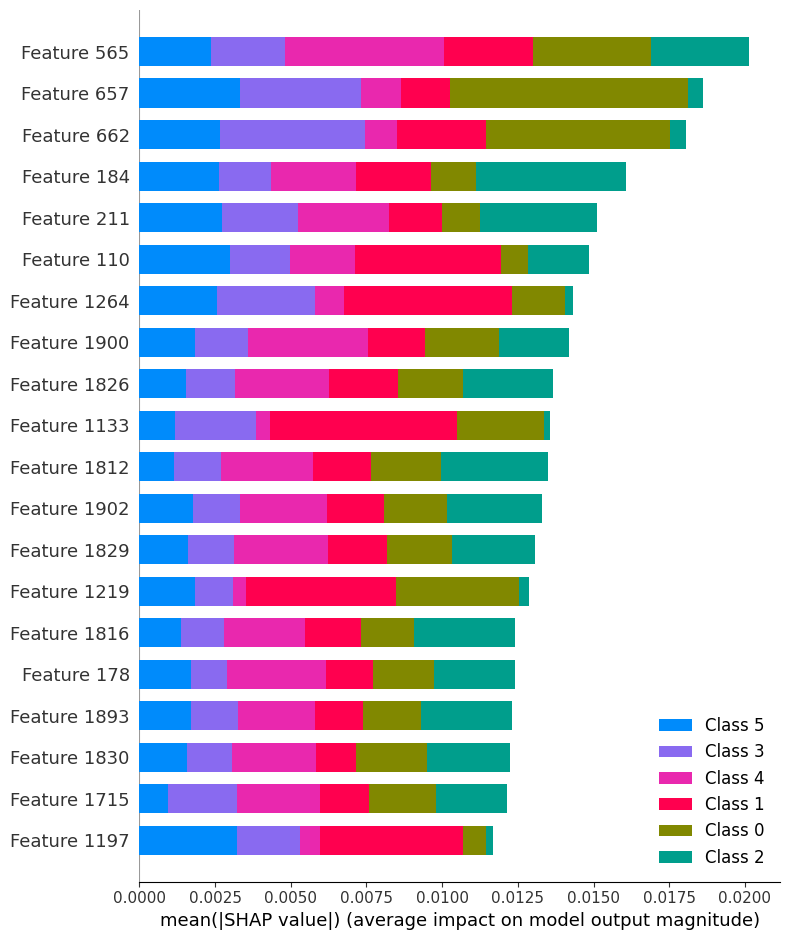

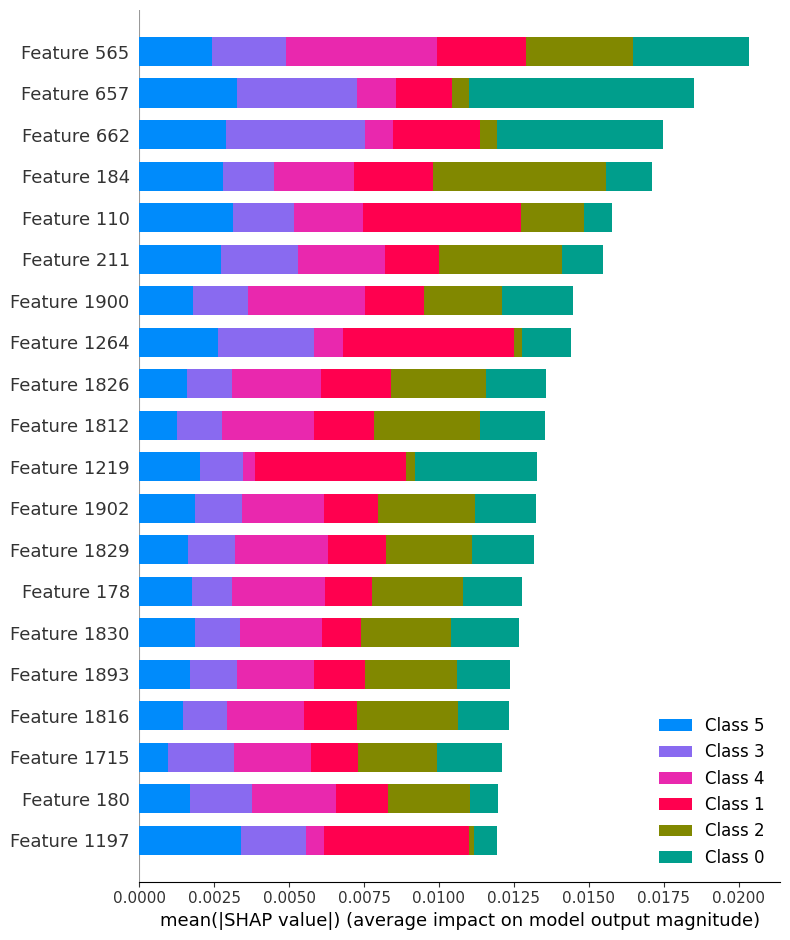

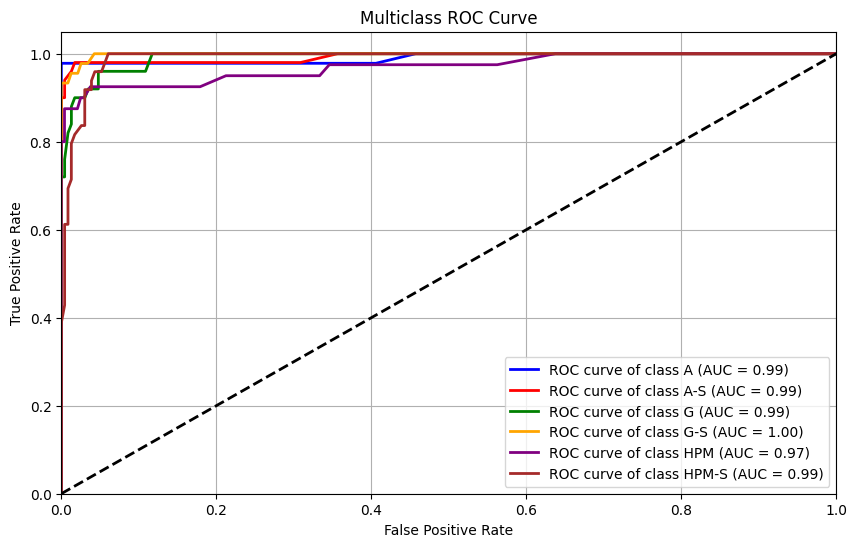

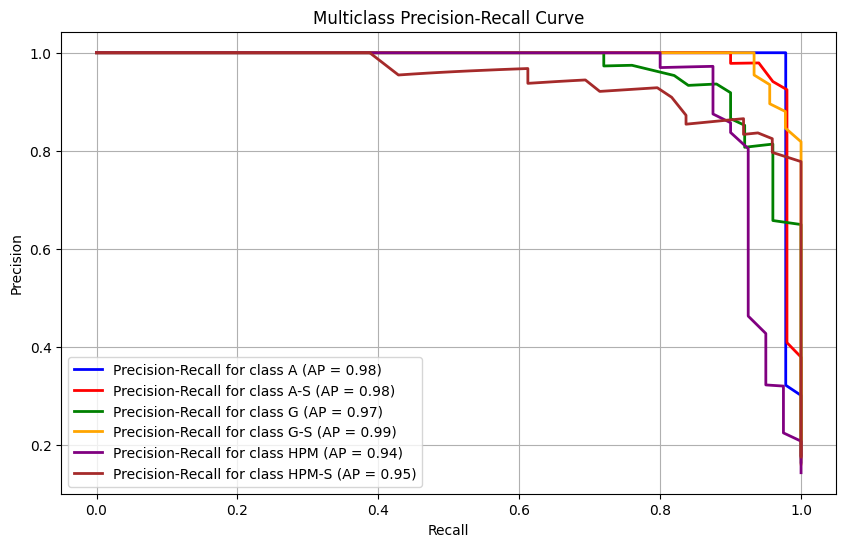

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import shap
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.metrics import (
    confusion_matrix, accuracy_score, classification_report,
    roc_curve, auc, precision_recall_curve, average_precision_score
)
from itertools import cycle

# Load the dataset
file_path = 'project 2 sap.csv'
data = pd.read_csv(file_path)

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(data['Lable'])
X = data.drop(columns=['Type', 'Lable']).values

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Train the model
model = RandomForestClassifier(random_state=42)
model.fit(X_train_split, y_train_split)

# Predictions
y_pred_val = model.predict(X_val)
y_pred_test = model.predict(X_test)

# Accuracy
val_accuracy = accuracy_score(y_val, y_pred_val)
test_accuracy = accuracy_score(y_test, y_pred_test)
print(f'Validation Accuracy: {val_accuracy * 100:.2f}%')
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

# Classification report
print("\nClassification Report (Test Set):\n", classification_report(y_test, y_pred_test))

# Cross-validation scores
train_scores = cross_val_score(model, X_train_split, y_train_split, cv=5)
val_scores = cross_val_score(model, X_val, y_val, cv=5)
train_error_rates = 1 - train_scores
val_error_rates = 1 - val_scores
epochs = np.arange(1, len(train_scores) + 1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_scores, label='Training Accuracy', marker='o')
plt.plot(epochs, val_scores, label='Validation Accuracy', marker='o')
plt.xlabel('Cross-Validation Folds')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs, train_error_rates, label='Training Error Rate', marker='o', color='red')
plt.plot(epochs, val_error_rates, label='Validation Error Rate', marker='o', color='orange')
plt.xlabel('Cross-Validation Folds')
plt.ylabel('Error Rate (1 - Accuracy)')
plt.legend()
plt.title('Training and Validation Error Rates')
plt.tight_layout()
plt.show()

# Confusion matrix (manually defined one)
cm_manual = np.array([
    [45, 0, 1, 0, 0, 0],
    [0, 48, 0, 0, 1, 1],
    [0, 0, 48, 0, 1, 1],
    [0, 0, 0, 43, 0, 2],
    [0, 1, 4, 0, 33, 2],
    [0, 1, 2, 2, 1, 43]
])
class_labels = ['A', 'A-S', 'G', 'G-S', 'HPM', 'HPM-S']

# Confusion matrix metrics
def get_confusion_matrix_metrics(cm, class_index):
    TP = cm[class_index, class_index]
    FP = cm[:, class_index].sum() - TP
    TN = np.delete(np.delete(cm, class_index, 0), class_index, 1).sum()
    FN = cm[class_index, :].sum() - TP
    return TP, FP, TN, FN

for i, class_label in enumerate(class_labels):
    TP, FP, TN, FN = get_confusion_matrix_metrics(cm_manual, i)
    print(f"Class: {class_label}")
    print(f"  True Positives (TP): {TP}")
    print(f"  False Positives (FP): {FP}")
    print(f"  True Negatives (TN): {TN}")
    print(f"  False Negatives (FN): {FN}")
    print("------------------------------------------------")

# Confusion matrix for test set
cm_test = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Test Set Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# SHAP values
explainer = shap.TreeExplainer(model)
shap_values_val = explainer.shap_values(X_val)
shap.summary_plot(shap_values_val, X_val, plot_type="bar")

shap_values_test = explainer.shap_values(X_test)
shap.summary_plot(shap_values_test, X_test, plot_type="bar")

# ROC and Precision-Recall Curves
y_test_bin = label_binarize(y_test, classes=np.unique(y))
n_classes = y_test_bin.shape[1]
y_score = model.predict_proba(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
precision = dict()
recall = dict()
avg_precision = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
    avg_precision[i] = average_precision_score(y_test_bin[:, i], y_score[:, i])

colors = cycle(['blue', 'red', 'green', 'orange', 'purple', 'brown'])

# ROC Curve
plt.figure(figsize=(10, 6))
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {label_encoder.classes_[i]} (AUC = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Precision-Recall Curve
plt.figure(figsize=(10, 6))
for i, color in zip(range(n_classes), colors):
    plt.plot(recall[i], precision[i], color=color, lw=2,
             label=f'Precision-Recall for class {label_encoder.classes_[i]} (AP = {avg_precision[i]:0.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Multiclass Precision-Recall Curve')
plt.legend(loc="lower left")
plt.grid(True)
plt.show()
